In [1]:
# Importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import torch

2025-03-21 21:55:37.760980: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 21:55:37.771721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742604937.784522    8807 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742604937.788219    8807 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742604937.797646    8807 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Probar si funciona aceleración por GPU

print(tf.config.list_physical_devices('GPU'))
torch.cuda.is_available()


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [ ]:
# Esto es para utilizar toda la memoria de la GPU

gpuMem = 4096 # En MB

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            #tf.config.experimental.set_memory_growth(gpu, True)  # Permite crecimiento dinámico de memoria
            # 
             tf.config.experimental.set_virtual_device_configuration(
                 gpu,
                 [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=gpuMem)]
             )
    except RuntimeError as e:
        print(e)


In [4]:
# Cargar datos
df = pd.read_csv("ipsaCompleto.csv")  # Debe tener "Date" y "Price"
df["Fecha"] = pd.to_datetime(df["Fecha"])
df = df.sort_values("Fecha")  # Asegurar orden temporal

In [5]:
# Normalizar precios entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
df["Valor IPSA"] = scaler.fit_transform(df["Valor IPSA"].values.reshape(-1, 1))

# Crear datos de entrenamiento con ventanas de tiempo
def crear_secuencias(datos, ventana=30):
    X, y = [], []
    for i in range(len(datos) - ventana):
        X.append(datos[i:i+ventana])
        y.append(datos[i+ventana])
    return np.array(X), np.array(y)

ventana = 30  # Usar los últimos 30 días para predecir
X, y = crear_secuencias(df["Valor IPSA"].values, ventana)

# Dividir datos en entrenamiento y prueba
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Reshape para LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
# Definir modelo LSTM
modelo = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilar modelo
modelo.compile(optimizer="adam", loss="mean_squared_error")

# Entrenar modelo
modelo.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


/home/nekonix/.conda/envs/tomate/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070 - val_loss: 7.6218e-04
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.7102e-04 - val_loss: 5.9995e-04
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.6470e-04 - val_loss: 4.6855e-04
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.7868e-04 - val_loss: 0.0010
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.6686e-04 - val_loss: 9.3918e-04
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.6913e-04 - val_loss: 3.4885e-04
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.3603e-04 - val_loss: 2.9387e-04
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.0067e-04 - val_loss: 3.0175e-04
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.4876e-04 - val_loss: 2.9912e-04
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.1591e-04 - val_loss: 3.3759e-04
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.0454e-04 - val_

In [10]:
# Hacer predicción para mañana
ultimos_datos = df["Valor IPSA"].values[-ventana:].reshape(1, ventana, 1)
prediccion = modelo.predict(ultimos_datos)
prediccion_real = scaler.inverse_transform(prediccion.reshape(-1, 1))

print(f"Predicción del IPSA para mañana: {prediccion_real[0][0]:.2f}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Predicción del IPSA para mañana: 7668.30


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


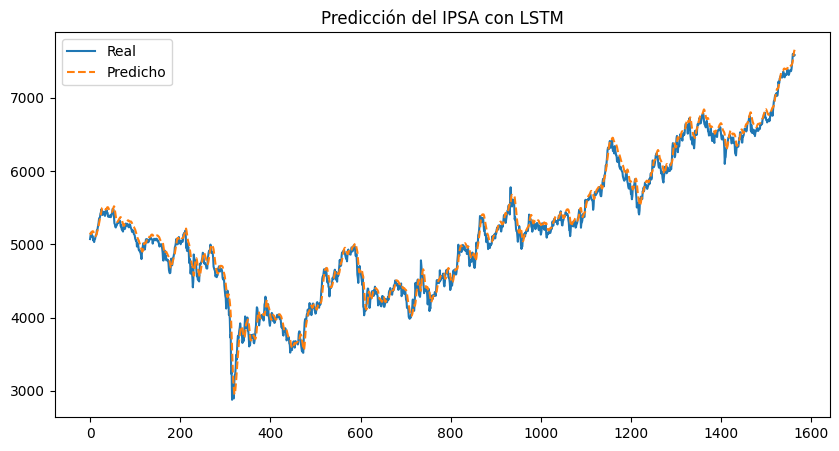

In [11]:
# Graficar predicciones vs. reales
predicciones = modelo.predict(X_test)
predicciones_real = scaler.inverse_transform(predicciones.reshape(-1, 1))
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_real, label="Real")
plt.plot(predicciones_real, label="Predicho", linestyle="dashed")
plt.legend()
plt.title("Predicción del IPSA con LSTM")
plt.show()